In [364]:
import pyspedas
import pytplot
# swe_vars = pyspedas.wind.swe(trange=['2003-11-20','2003-11-23'],datatype='h1',varnames=['BX','BY','BZ','Proton_Np_moment','Proton_Wpar_moment'],downloadonly=True)

**Using cdf_to_tplot PYTPLOT Function**

In [365]:

#Using cdf_to_tplot

# cdf = pytplot.cdf_to_tplot(r"wget_download\wi_h1_swe_20031120_v01.cdf",notplot=True)
# cdf.keys()
# cdf['BX']['y']

**Using CDFLIB**

In [366]:
import cdflib
cdf_file = cdflib.CDF(r'wget_download\wi_h1_swe_20031120_v01.cdf')
cdf_file.cdf_info()


CDFInfo(CDF=WindowsPath('C:/Users/KEVAL/Desktop/ICME-ML/wget_download/wi_h1_swe_20031120_v01.cdf'), Version='3.2.1', Encoding=1, Majority='Row_major', rVariables=[], zVariables=['fit_flag', 'Epoch', 'year', 'doy', 'Proton_V_nonlin', 'Proton_sigmaV_nonlin', 'Proton_VX_nonlin', 'Proton_sigmaVX_nonlin', 'Proton_VY_nonlin', 'Proton_sigmaVY_nonlin', 'Proton_VZ_nonlin', 'Proton_sigmaVZ_nonlin', 'Proton_W_nonlin', 'Proton_sigmaW_nonlin', 'Proton_Wperp_nonlin', 'Proton_sigmaWperp_nonlin', 'Proton_Wpar_nonlin', 'Proton_sigmaWpar_nonlin', 'EW_flowangle', 'SigmaEW_flowangle', 'NS_flowangle', 'SigmaNS_flowangle', 'Proton_Np_nonlin', 'Proton_sigmaNp_nonlin', 'Alpha_V_nonlin', 'Alpha_sigmaV_nonlin', 'Alpha_VX_nonlin', 'Alpha_sigmaVX_nonlin', 'Alpha_VY_nonlin', 'Alpha_sigmaVY_nonlin', 'Alpha_VZ_nonlin', 'Alpha_sigmaVZ_nonlin', 'Alpha_W_nonlin', 'Alpha_sigmaW_nonlin', 'Alpha_Wperp_nonlin', 'Alpha_sigmaWperp_nonlin', 'Alpha_Wpar_nonlin', 'Alpha_sigmaWpar_nonlin', 'Alpha_Na_nonlin', 'Alpha_sigmaNa_nonli

In [367]:
t_range= cdflib.cdfepoch.to_datetime(cdf_file.varget('epoch'))
t_range[:10]

array(['2003-11-20T00:01:12.248000', '2003-11-20T00:02:49.401000',
       '2003-11-20T00:04:26.554000', '2003-11-20T00:06:03.707000',
       '2003-11-20T00:07:40.861000', '2003-11-20T00:09:18.014000',
       '2003-11-20T00:10:55.167000', '2003-11-20T00:12:32.320000',
       '2003-11-20T00:14:09.473000', '2003-11-20T00:15:46.626000'],
      dtype='datetime64[us]')

**TPLOT PLOTTING**

In [368]:
# pytplot.store_data("BX",data={'x':t_range,'y':BX})
# pytplot.store_data("BY",data={'x':t_range,'y':BY})
# pytplot.store_data("BZ",data={'x':t_range,'y':BZ})

# pytplot.options("BX",'color','red')
# pytplot.options("BY",'color','blue')
# pytplot.options("BZ",'color','green')
# pytplot.options("Bmag","ytitle",r'$B_{vec}$')

# pytplot.options("BX", 'legend_names', 'BX')
# pytplot.options("BY", 'legend_names', 'BY')
# pytplot.options("BZ", 'legend_names', 'BZ')

# pytplot.store_data("Bmag",['BX','BY','BZ'])
# # help(pytplot.tplot_options)

# pytplot.options('border','true')

# pytplot.tplot(['Bmag'])

**MATPLOTLIB**

In [369]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

    # p_wpar[p_wpar > 9999] = np.nan
    # interpolated_data = pd.Series(p_wpar).interpolate()
    # p_war_new = interpolated_data.values


**Deriving the Parameters**

In [370]:
def bmagnitude(cdf_var : np.array) -> tuple:   # Bmagnitude #nT is Ok
    X = cdf_var.varget('BX')
    Y = cdf_var.varget('BY')
    Z = cdf_var.varget('BZ')

    bmag = np.sqrt( X**2 + Y**2 + Z**2 )
    if bmag[bmag >= 1000]:
        bmag[bmag >= 1000] = np.nan
        bmag = pd.Series(bmag).interpolate().values


    return X,Y,Z,bmag


def Vp_vec(cdf_var : np.array) -> np.array:   #Vp calculations
    vX = cdf_var.varget('Proton_VX_moment')
    vY = cdf_var.varget('Proton_VY_moment')
    vZ = cdf_var.varget('Proton_VZ_moment')

    vp_vec = np.sqrt( vX**2 + vY**2 + vZ**2 )
    
    if vp_vec[vp_vec >= 1000]:
        vp_vec[vp_vec >= 1000] = np.nan
        vp_vec = pd.Series(vp_vec).interpolate().values


    return vp_vec


def Temperature(cdf_var : np.array) -> np.array:   #Temp Calculations
    p_wpar = cdf_var.varget('Proton_W_moment')

    # p_wpar[p_wpar >= 99999] = np.nan
    # p_wpar_new = pd.Series(p_wpar).interpolate().values

    m_proton = 1.67e-27     # Mass of proton in kg
    k_boltzmann = 1.38e-23  # Boltzman constant
    vth_ms = p_wpar * 1000 # to make it m/s

    T = (m_proton * (vth_ms**2)) / (3 * k_boltzmann)

    return T

def plasma_beta(cdf_var: np.array,n_p,Bmag,T) -> np.array:   #plasma Beta calculations

    k_boltzmann = 1.380649e-23                      # Boltzmann constant 
    mu_0 = 4 * np.pi * 1e-7                         # Vacuum permeability in T m A^-1
    n_p = cdf_var.varget('Proton_Np_moment') * 1e6  # Proton number density in m^-3 (example value)
                                                    # Plasma temperature in Kelvin (example value)

    # Magnetic field strength in nanoTesla (example value)
    B = Bmag * 1e-9            # Conversion from nanoTesla to Tesla

    # Calculate plasma beta
    p_beta = (n_p * k_boltzmann * T) / (B**2 / (2 * mu_0))

    return p_beta

    


In [371]:
#plotting variables

BX,BY,BZ,b_mag = bmagnitude(cdf_file)


p_density = cdf_file.varget('Proton_Np_moment')
if p_density[p_density >= 10000]:
    p_density[p_density >= 10000] = np.nan
    p_density = pd.Series(p_density).interpolate().values

vp = Vp_vec(cdf_file)

temp = Temperature(cdf_file)


p_beta = plasma_beta(cdf_file,p_density,b_mag,temp)


10-Apr-24 12:29:00: C:\Users\KEVAL\AppData\Local\Temp\ipykernel_6564\3225578069.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bmag[bmag >= 1000]:

10-Apr-24 12:29:00: C:\Users\KEVAL\AppData\Local\Temp\ipykernel_6564\3225578069.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if vp_vec[vp_vec >= 1000]:



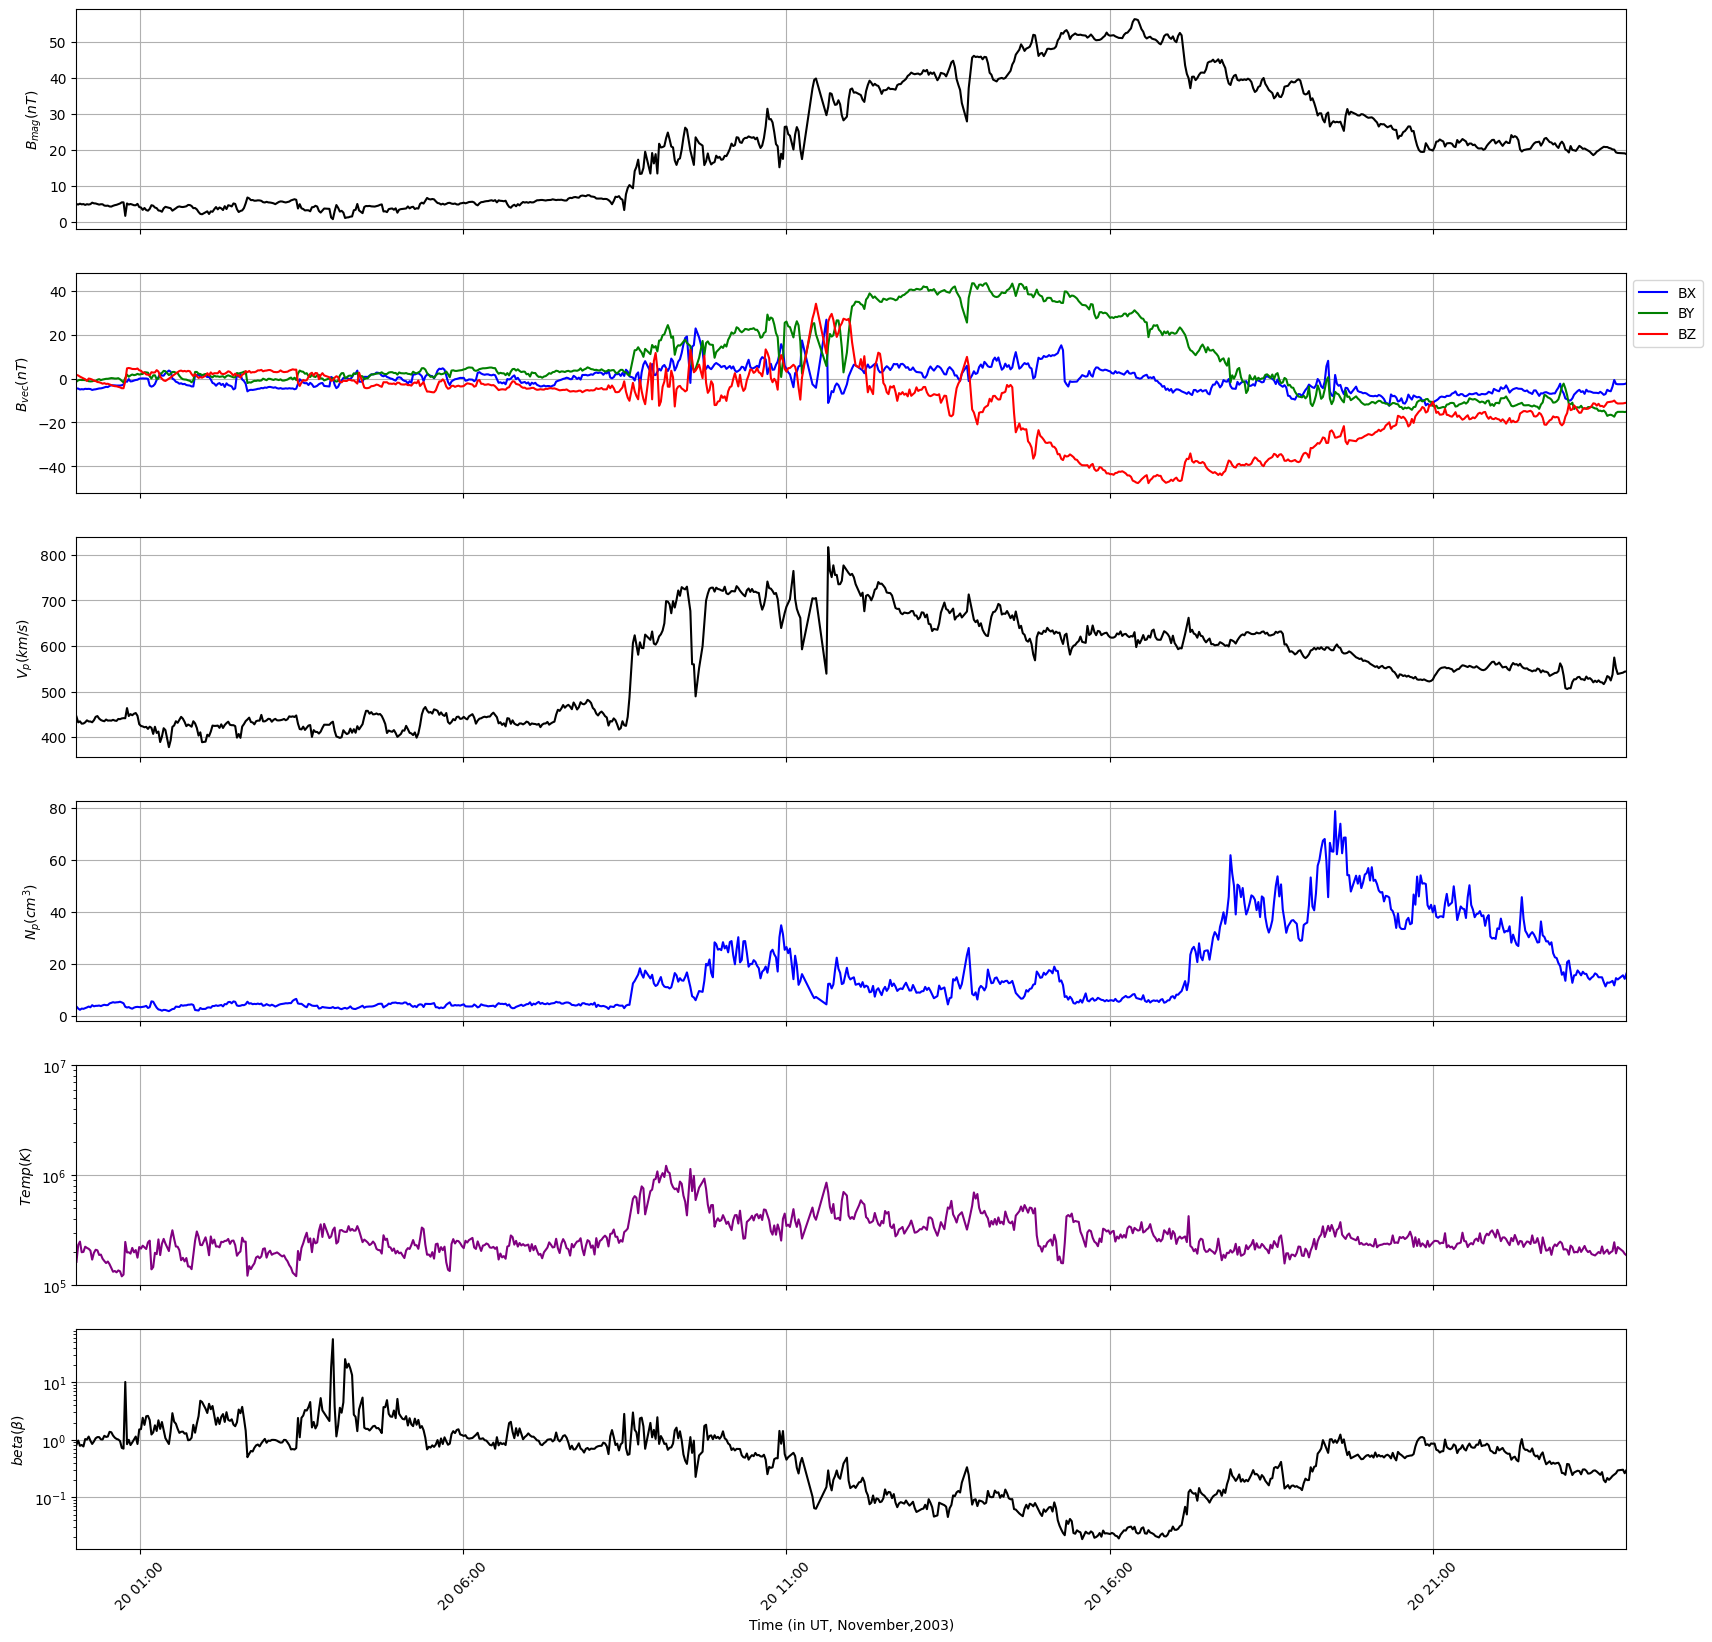

In [372]:
fig,ax = plt.subplots(6, 1,sharex=True, figsize=(20, 20))

# Set x-axis ticks to show intervals of 6 hours
hours = mdates.HourLocator(interval=5)
h_fmt = mdates.DateFormatter('%d %H:%M')  # Hour and minute format

plt.gca().xaxis.set_major_locator(hours)
plt.gca().xaxis.set_major_formatter(h_fmt)

plt.xlim(t_range[0], t_range[-1])
plt.xticks(rotation=45)

#plotting of BMAG
# ax[0].set_ylim(min(b_mag),max(b_mag))
# ax[0].set_yticks(np.arange(0, 51, 20))
ax[0].set_ylabel(r'$B_{mag} (nT)$')
ax[0].plot(t_range,b_mag,color='black')
ax[0].grid(True)



#Plotting for BX,BY,BZ
ax[1].set_ylabel(r'$B_{vec} (nT)$')
# ax[1].tick_params(axis='x',)
ax[1].plot(t_range,BX,label ='BX',color='blue')
ax[1].plot(t_range,BY,label ='BY',color='green')
ax[1].plot(t_range,BZ,label ='BZ',color='red')
ax[1].legend(loc="upper left",bbox_to_anchor=(1, 1))

ax[1].grid(True)



#plotting vp -> pvec

ax[2].set_ylabel(r'$V_{p} (km/s)$')
ax[2].plot(t_range,vp,color='black')
ax[2].grid(True)

#Plotting for Np -> Proton density

ax[3].set_ylabel(r'$N_{p} (cm^{3})$')
ax[3].plot(t_range,p_density,color='blue')
ax[3].grid(True)





#Plotting for Temp

# ax[4].set_yscale('log')
# def scientific_formatter(x, pos):
#     if x <= 0:  # Handle zero or negative values
#         return '0'
#     else:
#         return f'$10^{{{int(np.log10(x))}}}$'

# # Set the y-axis tick formatter
# ax[4].yaxis.set_major_formatter(FuncFormatter(scientific_formatter))

ax[4].set_yscale('log')

y_min, y_max = np.min(temp), np.max(temp)

y_min_order = int(np.floor(np.log10(y_min)))
y_max_order = int(np.ceil(np.log10(y_max)))

# Set y-axis limits to span the range of orders of magnitude
ax[4].set_ylim(10**y_min_order, 10**y_max_order)
ax[4].plot(t_range,temp,color='purple')
ax[4].set_ylabel(r'$Temp (K)$')
ax[4].grid(True)


#beta plasma
ax[5].set_yscale('log')
ax[5].plot(t_range,p_beta,color='black')
ax[5].set_ylabel(r'$beta (β)$')
ax[5].set_xlabel('Time (in UT, November,2003)')


ax[5].grid(True)


In [ ]:
import pandas as pd

# Example time series data with missing values
data = pd.Series([1, 2, None, 4, None, 6])

# Interpolate missing values using linear interpolation
interpolated_data = data.interpolate(method='linear')

print("Original data:")
print(data)
print("\nInterpolated data:")
print(interpolated_data)
